<a href="https://colab.research.google.com/github/DumboDhruvi/stocklens/blob/main/stocklens2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required libraries
!pip install yfinance ta --quiet

# Essential libraries
import yfinance as yf
import ta
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error

# Keras libraries for building models
from keras.models import Sequential, load_model, Model
from keras.layers import LSTM, Dense, Dropout, Input

# Visualization
import matplotlib.pyplot as plt

# For saving/loading models and data
import pickle

# OS management
import os


In [ ]:
def prepare_stock_data(ticker: str, start_date='2015-01-01', end_date='2023-01-01'):
    # Step 1: Download stock data using yfinance
    stock_data = yf.download(ticker, start=start_date, end=end_date)

    # Step 2: Convert the relevant columns into arrays and flatten them
    open_array = stock_data['Open'].values.flatten()
    high_array = stock_data['High'].values.flatten()
    low_array = stock_data['Low'].values.flatten()
    close_array = stock_data['Close'].values.flatten()
    volume_array = stock_data['Volume'].values.flatten()

    # Step 3: Create a new DataFrame using the arrays
    df = pd.DataFrame({
        'open': open_array,
        'high': high_array,
        'low': low_array,
        'close': close_array,
        'volume': volume_array
    })

    # Step 4: Calculate Technical Indicators using the ta library
    # RSI (Relative Strength Index)
    df['RSI'] = ta.momentum.RSIIndicator(df['close'], window=14).rsi()

    # MACD (Moving Average Convergence Divergence)
    macd_indicator = ta.trend.MACD(df['close'], window_slow=26, window_fast=12, window_sign=9)
    df['MACD'] = macd_indicator.macd()
    df['MACD_signal'] = macd_indicator.macd_signal()

    # Bollinger Bands
    bb_indicator = ta.volatility.BollingerBands(df['close'], window=20, window_dev=2)
    df['bb_bbm'] = bb_indicator.bollinger_mavg()  # Middle band (moving average)
    df['bb_bbh'] = bb_indicator.bollinger_hband()  # Upper band (high band)
    df['bb_bbl'] = bb_indicator.bollinger_lband()  # Lower band (low band)

    # Volatility (rolling standard deviation)
    df['Volatility'] = df['close'].rolling(window=20).std()

    # Simple Moving Average (50)
    df['SMA_50'] = ta.trend.SMAIndicator(df['close'], window=50).sma_indicator()

    # Exponential Moving Average (200)
    df['EMA_200'] = ta.trend.EMAIndicator(df['close'], window=200).ema_indicator()

    # Target price for future prediction (next day's close price)
    df['Target_Price'] = df['close'].shift(-1)

    # Drop any rows with NaN values (due to shifts or rolling operations)
    df = df.dropna()

    # Return the prepared DataFrame
    return df


NameError: name 'stock_data' is not defined

In [ ]:
def create_time_series_data(data, window_size=50):
    """
    Create time-series data for training models by sliding a fixed-size window over the dataset.

    Parameters:
    - data (numpy.ndarray): 2D array of shape (timesteps, features) representing the time-series data.
    - window_size (int): Number of time steps in each input sequence. Default is 50.

    Returns:
    - X (numpy.ndarray): 3D array of shape (samples, window_size, features).
    - y (numpy.ndarray): 2D array of shape (samples, features) or 1D array if data has one feature.
    """
    if not isinstance(data, np.ndarray) or len(data.shape) != 2:
        raise ValueError("Input data must be a 2D NumPy array.")
    if window_size >= len(data):
        raise ValueError("Window size must be smaller than the length of the data.")

    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size, :])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)


In [ ]:
def prepare_and_combine_stock_data(
    tickers, input_scaler, output_scaler, test_size=0.2, random_state=42, window_size=50
):
    """
    Prepare and combine data from multiple stocks into single training and testing datasets,
    including price labels only (no risk data).
    """
    features = ['RSI', 'MACD', 'bb_bbh', 'bb_bbm', 'bb_bbl', 'Volatility',
                'SMA_50', 'EMA_200', 'open', 'high', 'low', 'close', 'volume']

    combined_features = []
    combined_target_prices = []

    for ticker in tickers:
        try:
            print(f"Processing {ticker}...")
            stock_data = prepare_stock_data(ticker)
            X = stock_data[features].values
            y_price = stock_data['Target_Price'].values.reshape(-1, 1)

            combined_features.append(X)
            combined_target_prices.append(y_price)
        except Exception as e:
            print(f"Error processing {ticker}: {e}")

    if not combined_features:
        raise ValueError("No valid stock data to process. Please check input tickers.")

    if not hasattr(input_scaler, 'n_features_in_'):
        print("Fitting input scaler...")
        input_scaler.fit(np.vstack(combined_features))

    if not hasattr(output_scaler, 'n_features_in_'):
        print("Fitting output scaler...")
        output_scaler.fit(np.vstack(combined_target_prices))

    X_train_combined, X_test_combined = [], []
    y_train_price_combined, y_test_price_combined = [], []

    for ticker, X, y_price in zip(tickers, combined_features, combined_target_prices):
        try:
            X_scaled = input_scaler.transform(X)
            y_price_scaled = output_scaler.transform(y_price)

            X_ts, _ = create_time_series_data(X_scaled, window_size)
            _, y_price_ts = create_time_series_data(y_price_scaled, window_size)

            X_train, X_test, y_price_train, y_price_test = train_test_split(
                X_ts, y_price_ts, test_size=test_size, random_state=random_state
            )

            X_train_combined.append(X_train)
            X_test_combined.append(X_test)
            y_train_price_combined.append(y_price_train)
            y_test_price_combined.append(y_price_test)

            print(f"Processed {ticker}: X_train shape {X_train.shape}, y_train shape {y_price_train.shape}")

        except Exception as e:
            print(f"Error processing {ticker}: {e}")

    if not X_train_combined:
        raise ValueError("No data available to combine. Check if all tickers have valid data.")

    feature_dims = {x.shape[2] for x in X_train_combined}
    if len(feature_dims) > 1:
        raise ValueError("Mismatch in the number of features across stocks.")

    X_train_combined = np.vstack(X_train_combined)
    X_test_combined = np.vstack(X_test_combined)
    y_train_price_combined = np.concatenate(y_train_price_combined)
    y_test_price_combined = np.concatenate(y_test_price_combined)

    with open("input_scaler.pkl", "wb") as input_file:
        pickle.dump(input_scaler, input_file)
    with open("output_scaler.pkl", "wb") as output_file:
        pickle.dump(output_scaler, output_file)

    print("Scalers saved as 'input_scaler.pkl' and 'output_scaler.pkl'.")

    return X_train_combined, X_test_combined, y_train_price_combined, y_test_price_combined


In [ ]:
class StockPredictionModel:
    def __init__(self, input_shape, model_path="combined_stock_model.h5"):
        """
        Initialize the StockPredictionModel class.

        Parameters:
        - input_shape (tuple): Shape of the input data (timesteps, features).
        - model_path (str): Path to save/load the model.
        """
        self.input_shape = input_shape
        self.model_path = model_path
        self.model = self._build_model()

    def _build_model(self):
        """
        Build the LSTM model architecture for single-output price prediction.

        Returns:
        - model: Compiled Keras model.
        """
        # Define the input layer
        inputs = Input(shape=self.input_shape)

        # Add LSTM layers
        x = LSTM(units=64, return_sequences=True)(inputs)
        x = Dropout(0.3)(x)
        x = LSTM(units=64, return_sequences=False)(x)
        x = Dropout(0.3)(x)

        # Add output layer for price prediction
        output_price = Dense(units=1, name="price_output")(x)  # Future price prediction

        # Build the model
        model = Model(inputs=inputs, outputs=output_price)

        # Compile the model with loss for price prediction
        model.compile(
            optimizer='adam',
            loss="mean_squared_error",  # For price prediction
        )
        return model

    def train(self, X_train, y_train_price, X_val, y_val_price, epochs=30, batch_size=32):
        """
        Train the model.

        Parameters:
        - X_train (array): Training features.
        - y_train_price (array): Training labels for price prediction.
        - X_val (array): Validation features.
        - y_val_price (array): Validation labels for price prediction.
        - epochs (int): Number of training epochs.
        - batch_size (int): Batch size for training.

        Returns:
        - history: Training history object.
        """
        history = self.model.fit(
            X_train,
            y_train_price,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_val, y_val_price),
            verbose=1
        )
        return history

    def save_model(self):
        """Save the trained model to a file."""
        self.model.save(self.model_path)
        print(f"Model saved to {self.model_path}")

    def load_model(self):
        """Load a pre-trained model from a file."""
        if os.path.exists(self.model_path):
            self.model = load_model(self.model_path)
            print(f"Model loaded from {self.model_path}")
        else:
            raise FileNotFoundError(f"No model file found at {self.model_path}")

    def predict(self, X):
        """
        Make predictions for price using the trained model.

        Parameters:
        - X (array): Input data for prediction.

        Returns:
        - predictions: Price predictions.
        """
        price_pred = self.model.predict(X)
        return price_pred

    def evaluate(self, X_test, y_test_price):
        """
        Evaluate the model on test data.

        Parameters:
        - X_test (array): Test features.
        - y_test_price (array): Test labels for price.

        Returns:
        - loss: Test loss for price prediction.
        """
        loss = self.model.evaluate(
            X_test,
            y_test_price,
            verbose=1
        )
        print(f"Test Loss: {loss}")
        return loss


In [ ]:
def train_stock_model(tickers):
    """
    Train a stock prediction model without considering risk data.

    Args:
    - tickers (list): List of stock tickers to process and train the model on.

    Returns:
    - None: Saves the trained model and scalers to disk and plots the predictions.
    """
    # Initialize scalers
    input_scaler = MinMaxScaler(feature_range=(0, 1))
    output_scaler = MinMaxScaler(feature_range=(0, 1))

    # Prepare and combine stock data
    X_train_combined, X_test_combined, y_train_price, y_test_price = prepare_and_combine_stock_data(
        tickers, input_scaler, output_scaler, test_size=0.2, random_state=42, window_size=50
    )

    # Reshape inputs for LSTM
    X_train_seq = X_train_combined  # Shape: (samples, timesteps, features)
    X_test_seq = X_test_combined    # Shape: (samples, timesteps, features)

    # Define input shape
    input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])  # (timesteps, features)

    # Initialize the model
    model_path = "combined_stock_model.h5"
    stock_model = StockPredictionModel(input_shape=input_shape, model_path=model_path)

    # Train the model
    stock_model.train(
        X_train_seq, y_train_price,  # Only price-related arguments
        X_test_seq, y_test_price,    # Only price-related arguments
        epochs=30, batch_size=32
    )

    # Save the model
    stock_model.save_model()

    # Save the scalers
    input_scaler_path = "input_scaler.pkl"
    output_scaler_path = "output_scaler.pkl"
    with open(input_scaler_path, "wb") as f_in, open(output_scaler_path, "wb") as f_out:
        pickle.dump(input_scaler, f_in)
        pickle.dump(output_scaler, f_out)
    print(f"Scalers saved to {input_scaler_path} and {output_scaler_path}")

    # Predict test values
    predicted_price = stock_model.model.predict(X_test_seq)

    # Prepare the placeholder for inverse scaling of predictions
    placeholder = np.zeros((predicted_price.shape[0], X_test_combined.shape[2]))
    placeholder[:, -1] = predicted_price.flatten()
    predicted_price_scaled = output_scaler.inverse_transform(placeholder)[:, -1]

    # Prepare the placeholder for inverse scaling of actual prices
    placeholder[:, -1] = y_test_price.flatten()
    y_test_price_scaled = output_scaler.inverse_transform(placeholder)[:, -1]

    # Calculate percentage accuracy
    percentage_difference = 100 * (predicted_price_scaled - y_test_price_scaled) / y_test_price_scaled
    accuracy = 100 - np.mean(np.abs(percentage_difference))
    print(f"Model Accuracy: {accuracy:.2f}%")

    # Plot actual vs predicted prices
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_price_scaled, label="Actual Prices", color="blue")
    plt.plot(predicted_price_scaled, label="Predicted Prices", color="orange")
    plt.title("Actual vs Predicted Prices")
    plt.xlabel("Time")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot predicted prices
    plt.figure(figsize=(12, 6))
    plt.plot(predicted_price_scaled, label="Predicted Prices", color="orange")
    plt.title("Predicted Stock Prices")
    plt.xlabel("Time")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot actual prices
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_price_scaled, label="Actual Prices", color="blue")
    plt.title("Actual Stock Prices")
    plt.xlabel("Time")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot percentage difference
    plt.figure(figsize=(12, 6))
    plt.plot(percentage_difference, label="Percentage Difference (%)", color="red")
    plt.title("Percentage Difference Between Actual and Predicted Prices")
    plt.xlabel("Time")
    plt.ylabel("Percentage Difference")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Training complete. Model saved to {model_path}")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Processing AAPL...
Processing TSLA...
Fitting input scaler...
Fitting output scaler...
Processed AAPL: X_train shape (1411, 50, 13), y_train shape (1411, 1)
Processed TSLA: X_train shape (1411, 50, 13), y_train shape (1411, 1)


Scalers saved as 'input_scaler.pkl' and 'output_scaler.pkl'.
Epoch 1/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - loss: 0.0107 - val_loss: 0.0011
Epoch 2/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 15s 72ms/step - loss: 0.0020 - val_loss: 8.9396e-04
Epoch 3/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - loss: 0.0022 - val_loss: 0.0010
Epoch 4/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - loss: 0.0018 - val_loss: 6.0658e-04
Epoch 5/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0020 - val_loss: 6.6205e-04
Epoch 6/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 0.0018 - val_loss: 6.7750e-04
Epoch 7/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 0.0014 - val_loss: 6.9845e-04
Epoch 8/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 9/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 10/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 0.0016 - val_loss: 5.3735e-04
Epoch 11/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 

Model saved to combined_stock_model.h5
Scalers saved to input_scaler.pkl and output_scaler.pkl
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Model Accuracy: 88.01%


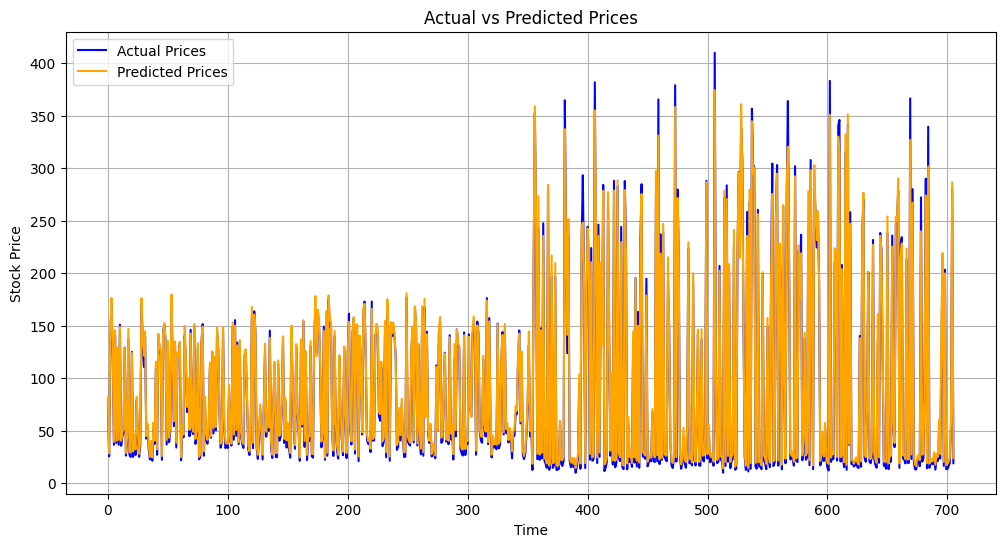

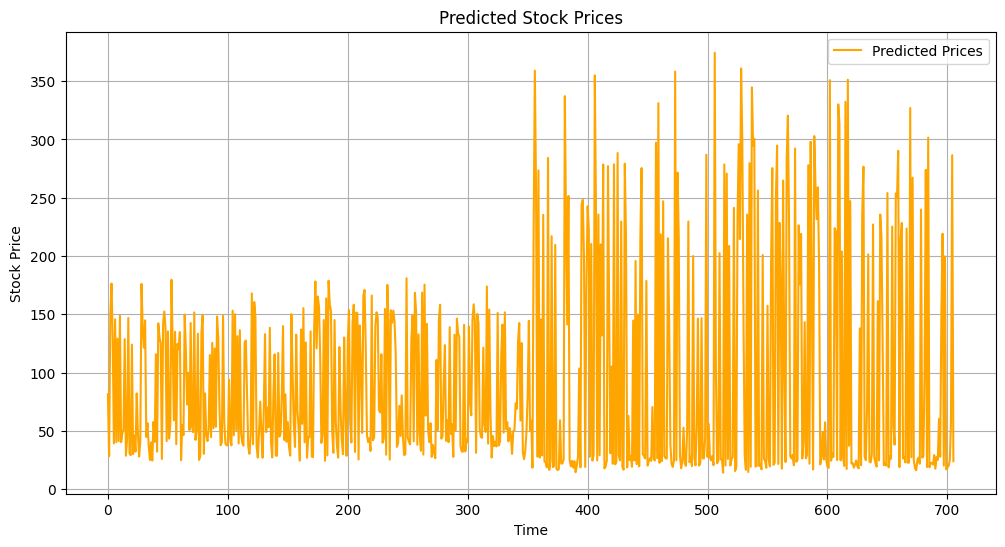

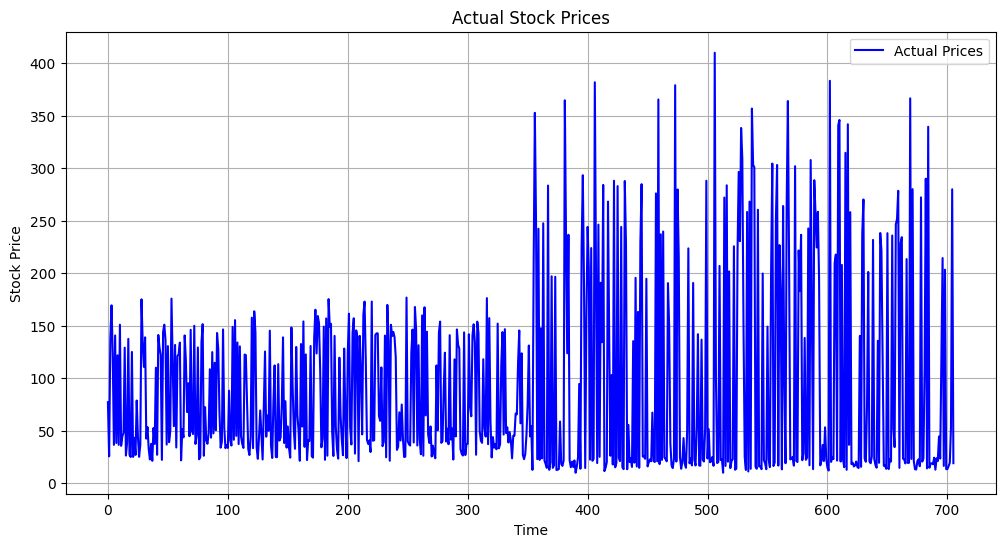

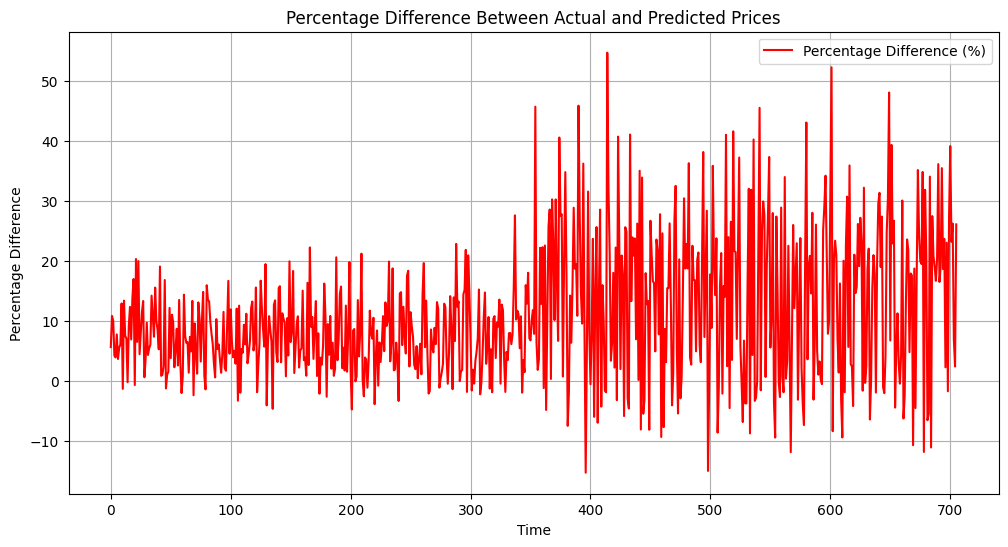

Training complete. Model saved to combined_stock_model.h5


In [ ]:
train_stock_model(["AAPL", "TSLA"])

In [ ]:
def test_stock_model(tickers, input_scaler_path="input_scaler.pkl", output_scaler_path="output_scaler.pkl", model_path="combined_stock_model.h5"):
    """
    Test the existing stock prediction model on new stock data.

    Args:
    - tickers (list): List of stock tickers to test the model on.
    - input_scaler_path (str): Path to the saved input scaler.
    - output_scaler_path (str): Path to the saved output scaler.
    - model_path (str): Path to the saved model.

    Returns:
    - None: Prints and visualizes model performance on new stock data.
    """
    # Load the scalers
    with open(input_scaler_path, "rb") as f_in, open(output_scaler_path, "rb") as f_out:
        input_scaler = pickle.load(f_in)
        output_scaler = pickle.load(f_out)
    print("Scalers loaded successfully.")

    # Load the pre-trained model
    model = load_model(model_path)
    print(f"Model loaded successfully from {model_path}")

    # Prepare new stock data
    _, X_test_combined, _, y_test_price = prepare_and_combine_stock_data(
        tickers, input_scaler, output_scaler, test_size=0.2, random_state=42, window_size=50
    )

    # Predict on new data
    predicted_price = model.predict(X_test_combined)

    # Prepare the placeholder for inverse scaling of predictions
    placeholder = np.zeros((predicted_price.shape[0], X_test_combined.shape[2]))
    placeholder[:, -1] = predicted_price.flatten()
    predicted_price_scaled = output_scaler.inverse_transform(placeholder)[:, -1]

    # Prepare the placeholder for inverse scaling of actual prices
    placeholder[:, -1] = y_test_price.flatten()
    y_test_price_scaled = output_scaler.inverse_transform(placeholder)[:, -1]

    # Calculate percentage accuracy
    percentage_difference = 100 * (predicted_price_scaled - y_test_price_scaled) / y_test_price_scaled
    accuracy = 100 - np.mean(np.abs(percentage_difference))
    print(f"Model Accuracy on New Data: {accuracy:.2f}%")

    # Plot predictions vs actual prices
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_price_scaled, label="Actual Prices", color="blue")
    plt.plot(predicted_price_scaled, label="Predicted Prices", color="orange")
    plt.title(f"Actual vs Predicted Prices for {', '.join(tickers)}")
    plt.xlabel("Time")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot percentage difference
    plt.figure(figsize=(12, 6))
    plt.plot(percentage_difference, label="Percentage Difference (%)", color="red")
    plt.title(f"Percentage Difference for {', '.join(tickers)}")
    plt.xlabel("Time")
    plt.ylabel("Percentage Difference")
    plt.legend()
    plt.grid(True)
    plt.show()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Scalers loaded successfully.
Model loaded successfully from combined_stock_model.h5
Processing GOOGL...
Processing AMZN...
Processed GOOGL: X_train shape (1411, 50, 13), y_train shape (1411, 1)


Processed AMZN: X_train shape (1411, 50, 13), y_train shape (1411, 1)
Scalers saved as 'input_scaler.pkl' and 'output_scaler.pkl'.
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Model Accuracy on New Data: 93.54%


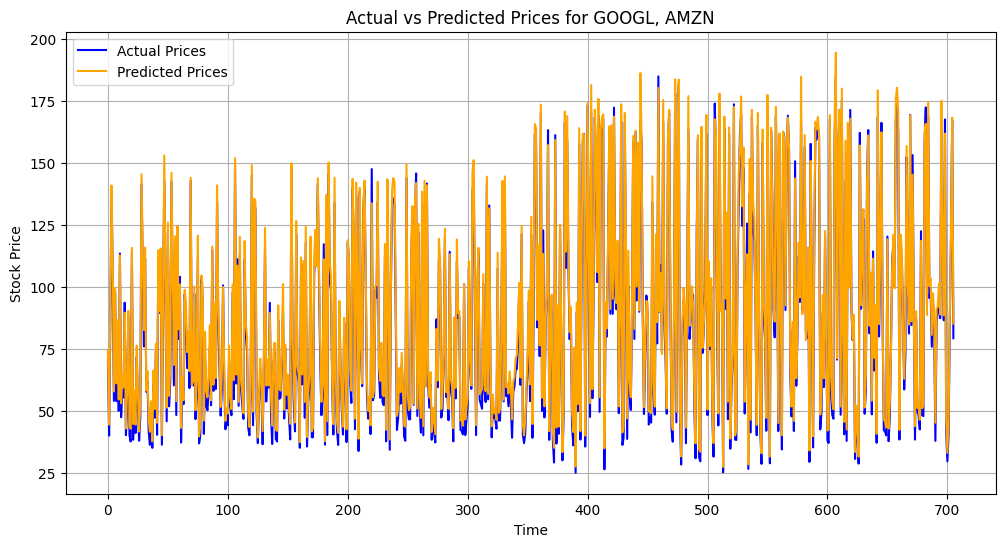

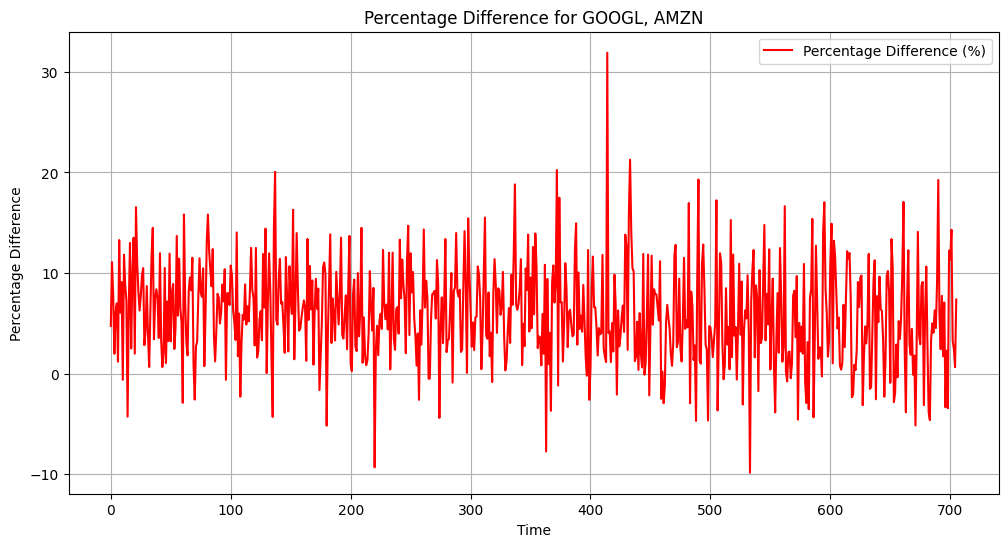

In [ ]:
test_stock_model(["GOOGL", "AMZN"])